# Tank2 and Tank5 phase regulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sklearn.mixture
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

%matplotlib widget
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["savefig.format"] = 'pdf'
plt.rc("axes",prop_cycle= plt.cycler("color", plt.cm.tab20.colors))

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler

print(tf.__version__)

2.12.0


## DNN regression models

The base model contains the following layers:

* The normalization layer.
* N hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear output layer.

We also test a model without input normalization layer.

In [3]:
def build_and_compile_model(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(32, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_len(norm, init_lr, numlabel):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(256, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(64, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(32, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(int(numlabel))
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_square(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'), #200
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model
def build_and_compile_model_nobatch(norm, init_lr):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'), #200
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model


def build_and_compile_model_nonorm(inputs,init_lr):
  model = keras.Sequential([
      keras.Input(shape=(inputs,)),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      #layers.Dense(100, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error', steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

def build_and_compile_model_LSTM(init_lr,numlabel):
  model = keras.Sequential([
      layers.LSTM(128, return_sequences=True),
      layers.LSTM(128),
      layers.Dense(int(numlabel))
  ])
  model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(init_lr))
  return model

## Define learning schedules and training

In [4]:
# Define learning schedules 

initial_lr = 0.001

def lr_time_based_decay(epoch, lr):
    epochs = 400
    decay = initial_lr / epochs
    return lr * 1 / (1 + decay * epoch)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 200.0
    return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_lr * math.exp(-k*epoch)



In [5]:
def train_model(model,features,labels,eps,lrs=None):
    if lrs is None:
        history = model.fit(
            features, 
            labels,
            validation_split=0.2,
            batch_size=64, #30
            verbose=0,
            epochs=int(eps)
        )
    else:
        history = model.fit(
            features, 
            labels, 
            validation_split=0.2,
            batch_size=64,
            verbose=0,
            epochs=int(eps), 
            callbacks=[LearningRateScheduler(lrs, verbose=0)],
        )
    return history

## Define plotting functions

In [6]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_multi_loss(histories):
    fig, ax = plt.subplots(len(histories),1,figsize=(9,9))
    for i in range(len(histories)):
        ax[i].plot(histories[i].history['loss'], label='loss')
        ax[i].plot(histories[i].history['val_loss'], label='val_loss')
        ax[i].set_ylim([0, 0.5])
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()
        ax[i].grid(True)
        
    fig.tight_layout()


In [7]:
def plot_2dhist(predictions,labels):

    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    fig.tight_layout()
    devs = ['V5QSET','RFQ','Buncher']
    
    if labels.shape[1] ==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        h = ax[i].hist2d(labels.iloc[:,i], predictions[:,i], bins=40, cmin=1, cmap='seismic')
        #ax.set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        ax[i].set(title='%s'%key)
        ax[i].tick_params(axis='both',labelsize=14)
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        ax[i].plot(lims, lims, color='k')
        fig.colorbar(h[3], ax=ax[i])

    fig.supylabel('Predicted $\Delta$ phase (deg)', fontsize=18)
    fig.suptitle('True $\Delta$ phase (deg)', y=0.05, fontsize=18)   
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.14)
    plt.subplots_adjust(right=0.96)  

In [8]:
def plot_2dscatter_many(predictions,labels):

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5))
    if labels[0].shape[1] ==1:
        ax = [ax]

    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]

        for j in range(len(labels)):
            ax[i].scatter(labels[j].iloc[:,i], predictions[j][:,i], label='Data %d'%j)
            #ax[i].fill_between(labels[j].iloc[:,i],[np.min(predictions[j][k,i]) for k in ],np.max(predictions[j][:,i]),alpha=0.5)
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min([np.min(pred[:,i]) for pred in predictions]),np.min([np.min(lab.iloc[:,i]) for lab in labels])),
                max(np.max([np.max(pred[:,i]) for pred in predictions]),np.max([np.max(lab.iloc[:,i]) for lab in labels]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        #print(lims)
        ax[i].plot(lims, lims, color='b')
        ax[i].legend(ncol=2,fontsize=14, loc='upper left')
    fig.tight_layout()

In [9]:
def plot_2dscatter(predictions,labels):

    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    if labels.shape[1] ==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        ax[i].scatter(labels.iloc[:,i], predictions[:,i], color='r')
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        print(lims)
        ax[i].plot(lims, lims, color='b')    
    fig.tight_layout()

In [10]:
def plot_1derror(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    devs = ['phase set point']
    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5),sharey=False)
    fig.tight_layout()
    
    nbins=60
    if labels.shape[1]==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        error =(predictions[:,i] - labels.iloc[:,i])
        error = [e for e in error if e <3*np.std(error)]

        ax[i].hist(error, bins=nbins, color='r', edgecolor='k', alpha=0.65, label='Data')
        #ax[i].set(title='%s'%key ,xlabel='Prediction Error (deg)', ylabel='Count')
        ax[i].set(title='%s'%key)
        #ax[i].xaxis.label.set_size(13)
        #ax[i].yaxis.label.set_size(13)
        
        ers = np.array(error)[:,None]
        gmm = sklearn.mixture.GaussianMixture()  
        r = gmm.fit(ers)
        mean = r.means_[0, 0]
        sigma = np.sqrt(r.covariances_[0,0])
        textstr = '\n'.join((
                    r'$\mu=%.2f$' % (mean,),
                    r'$\sigma=%.2f$' % (sigma,)))
        print(textstr)                                                                                                                  
        xlin = np.linspace(np.min(error),np.max(error),1000).reshape(-1,1)                                                                                                                             
        pdf = np.exp(gmm.score_samples(xlin))
        binsize = (np.max(error) - np.min(error))/nbins
        ax[i].plot(xlin,pdf*(len(error)*binsize),color='k', label='Gauss fit')
        ax[i].text(0.05, 0.65, textstr, transform=ax[i].transAxes, color='k', fontsize=14,                                                                                
                           verticalalignment='top', bbox=props)
        ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  


In [11]:
def plot_1derror_many(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5),sharey=False)
    fig.tight_layout()
    if labels[0].shape[1]==1:
        ax = [ax]
    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]
        nbins=40
        for j in range(len(labels)):
            error =(predictions[j][:,i] - labels[j].iloc[:,i])
            error = [e for e in error if e <1*np.std(error)]
            if i not in[2,3]:
                ax[i].hist(error, bins=nbins, alpha=0.45, label='Data')
            else:
                ax[i].hist(error, bins=100, alpha=0.45, label='Data')
        ax[i].set(title='%s'%key)
        #ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=18)
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize=18)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  


## Define data loading functions

In [12]:
def fetch_data(file,datacols,cuts,setdevs):
    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]
    
    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter')),axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)
    
    # augment jumps in phase data
    #subset['B:BQ3F'] = subset['B:BQF3'].apply(lambda x : x if x > 0 else x +360)
    subset.dropna()
    
    return subset

In [13]:
def fetch_reference(dataset,devs,setvals,stepsize):
    
    conds = ["(np.abs(dataset['%s']-%s)<%f)"%(d,s,k) for (d,s,k) in zip(devs,setvals,stepsize)]

    #reference = dataset.loc[(np.abs(dataset[devs[0]]-setvals[0])<0.5)].mean()
    reference = dataset.loc[eval('&'.join(conds)).ravel()].mean()
    return reference

In [14]:
def fetch_slice(dataset,devs,setvals,stepsize):
    
    conds = ["(np.abs(dataset['%s']-%s)<%f)"%(d,s,k) for (d,s,k) in zip(devs,setvals,stepsize)]

    sliced = dataset.loc[eval('&'.join(conds)).ravel()]
    return sliced

In [15]:
def fetch_features_labels(dataset,targetdevs):
    features = dataset.copy()
    labelstr = list(dataset.filter(regex='|'.join(targetdevs)))
    labels = features.loc[:,labelstr]
    features.drop(columns=labelstr, inplace=True)
    
    return features,labels

In [16]:
# List of approximate BPM positions in meters
dist_data = [26.5,27.0, 43.5, 44.0,60.8, 77.0,78.3,79.6,
            80.8, 82.5, 84.4,
            88.2, 90.1, 92.1,
            96.3, 98.4, 100.6, 102.8,
            105.0, 109.6, 111.9,
            114.7, 116.7, 119.1, 121.6,
            124.0, 126.5, 129.6, 131.6,
            134.2, 136.8, 139.4, 141.6]
#D42 : 107.3

## 2-phase models: T2, T5 setting

In [17]:
onedegdata = r"..\Data\untitled folder 2\devicescan_26042023.csv"
files =[r"..\Data\BS2\BEAM STUDY 14DEC2022\devicescan.csv", r"..\Data\BS1\BEAM STUDY 09OCT2022\devicescan_rfq_t2_t5.csv"]
cavs = ['L:RFQPAH','L:V2QSET','L:V5QSET']
#cavs = ['L:V2QSET','L:V5QSET']

path = ""
dfs = [fetch_data('%s%s'%(path,f),cavs+['BF','BPM'],'',['%s_R'%c[2:] for c in cavs]) for f in files]

dfs = [df.drop(list(df.filter(regex=r'20|B:|SS|SQT|2OF|D42')),axis=1) for df in dfs]


# quality cuts 
dfs[0].iloc[0,:] = dfs[0].iloc[1,:]
dfs[0].iloc[99,:] = dfs[0].iloc[100,:]
dfs[0].iloc[297,:] = dfs[0].iloc[298,:]
dfs[0].iloc[1386,:] = dfs[0].iloc[1387,:]
dfs[0].iloc[1477,:] = dfs[0].iloc[1478,:]
dfs[0].iloc[1683,:] = dfs[0].iloc[1684,:]
dfs[0].iloc[1738,:] = dfs[0].iloc[1739,:]
dfs[0].iloc[2574,:] = dfs[0].iloc[2575,:]
dfs[0].iloc[2673,:] = dfs[0].iloc[2674,:]
dfs[0].iloc[2970,:] = dfs[0].iloc[2971,:]
dfs[0].iloc[3960,:] = dfs[0].iloc[3961,:]
dfs[0].iloc[3982,:] = dfs[0].iloc[3983,:]
dfs[0].iloc[4950,:] = dfs[0].iloc[4951,:]
dfs[0].iloc[5346,:] = dfs[0].iloc[5347,:]
dfs[0].iloc[5445,:] = dfs[0].iloc[5446,:]
dfs[0].iloc[5841,:] = dfs[0].iloc[5842,:]
dfs[0].iloc[5940,:] = dfs[0].iloc[5941,:]
dfs[0].iloc[6435,:] = dfs[0].iloc[6436,:]
dfs[0].iloc[6534,:] = dfs[0].iloc[6535,:]
dfs[0].iloc[7128,:] = dfs[0].iloc[7129,:]
dfs[0].iloc[7326,:] = dfs[0].iloc[7327,:]
dfs[0].iloc[7623,:] = dfs[0].iloc[7624,:]
dfs[0].iloc[7821,:] = dfs[0].iloc[7822,:]
dfs[0].iloc[8118,:] = dfs[0].iloc[8119,:]
dfs[0].iloc[8910,:] = dfs[0].iloc[8911,:]
dfs[0].iloc[9207,:] = dfs[0].iloc[9208,:]
dfs[0].iloc[9306,:] = dfs[0].iloc[9307,:]
dfs[0].iloc[9603,:] = dfs[0].iloc[9604,:]
dfs[0].iloc[9801,:] = dfs[0].iloc[9802,:]
dfs[0].iloc[10098,:] = dfs[0].iloc[10099,:]
dfs[0].iloc[10494,:] = dfs[0].iloc[10495,:]
dfs[0].iloc[10890,:] = dfs[0].iloc[10891,:]
dfs[0].iloc[10989,:] = dfs[0].iloc[10990,:]
dfs[0].iloc[11088,:] = dfs[0].iloc[11089,:]
dfs[0].iloc[11286,:] = dfs[0].iloc[11287,:]
dfs[0].iloc[11884,:] = dfs[0].iloc[11885,:]
dfs[0] = dfs[0].iloc[:-1,:]


dfs[0] = dfs[0].loc[(dfs[0]['L:BPM3OF']>0)& 
                    (dfs[0]['L:BPM4IF']>0) & (dfs[0]['L:BPM5IF']<-87) & (dfs[0]['L:D13BF']<-17.5)&
                    (dfs[0]['L:D41BF']<-150)& (dfs[0]['L:D52BF']<-44)& (dfs[0]['L:D72BF']<-65)]

dfs[1].iloc[0,:] = dfs[1].iloc[1,:]
dfs[1].iloc[5940] = dfs[1].iloc[5941]
dfs[1] = dfs[1].iloc[:-1,:]

meds = [[np.median(df[c]) for c in cavs] for df in dfs]
#print(meds)

stepsize = [[3.,0.5,0.3],[3.9,0.35,0.4]]

refs = [fetch_reference(df,cavs,med,step) for df,med,step in zip(dfs,meds,stepsize)]
#print(refs)
ddfs = [df-ref for df,ref in zip(dfs,refs)]


df1deg = fetch_data('%s'%onedegdata,cavs[1:]+['BF','BPM'],'',['%s_R'%c[2:] for c in cavs[1:]])
df1deg = df1deg.drop(list(df1deg.filter(regex=r'20|B:|SS|SQT|2OF|D42')),axis=1)
df1deg = df1deg.iloc[:-1,:]
df1deg['L:BPM5OF'] = df1deg['L:BPM5OF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D53BF'] = df1deg['L:D53BF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D33BF'] = df1deg['L:D33BF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D41BF'] = df1deg['L:D41BF'].apply(lambda x : x if x > 0 else x +360)
df1deg = df1deg.loc[(df1deg['L:D72BF']<-65) & (df1deg['L:BPM4IF']>95) & (df1deg['L:D23BF']<100)]

ref1deg =fetch_reference(df1deg,cavs[1:],[np.median(df1deg[c]) for c in cavs[1:]],[0.99,0.99])
ddf1deg = df1deg-ref1deg



(1085, 35)
(99, 35)


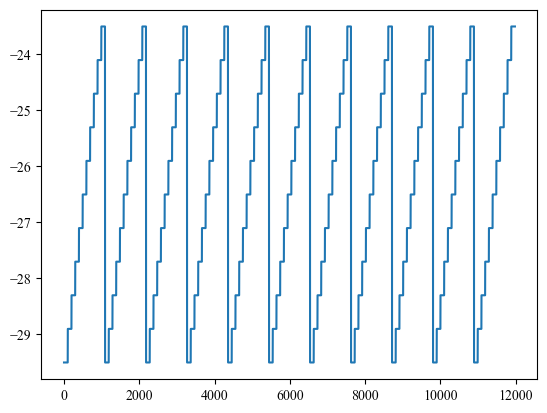

In [18]:
%matplotlib inline
plt.plot(dfs[0]['L:V2QSET'])
dff = dfs[0].loc[np.abs(dfs[0]['L:RFQPAH']-178.57)<1.]

dff =dff.sort_index().reset_index(drop=True)
dff.dropna(inplace=True)
print(dff.shape)
dff.head(10)
dff.to_csv('training_t2t5_oscillation.csv')

dfff = dfs[0].loc[(np.abs(dfs[0]['L:V2QSET']+26.5)<0.5) & (np.abs(dfs[0]['L:V5QSET']+32.41)<0.3)]
#dfff = dfs[0].loc[(np.abs(dfs[0]['L:V2QSET']-26.5)<0.3)]
dfff =dfff.sort_index().reset_index(drop=True)
dfff.dropna(inplace=True)
print(dfff.shape)
dfff.head(10)
dfff.to_csv('testing_upstream_oscillation.csv')
plt.show()

In [19]:
bpm = list(dff.columns)[3:]
res = dict(zip(bpm, dist_data))
import json

with open('sensor_positions.json', 'w') as fp:
    json.dump(res, fp)
    
baseline = dict(zip(cavs,meds[0]))
print(baseline)
with open('baseline_knobs.json', 'w') as fp:
    json.dump(baseline, fp)

{'L:RFQPAH': 178.57666015625, 'L:V2QSET': -26.5, 'L:V5QSET': -32.40999984741211}


## Plot BPM phase oscillation

In [20]:
ssdf = []
for i in range(3):
    cav = [c for c in cavs if c!=cavs[i]]
    ssdf.append([fetch_slice(df,cav,[0.,0.],[0.3,0.3]) for df in ddfs])
    #ssdf.append([fetch_slice(df,cav,[0.,0.],[0.9,0.9]) for df in ddfs])

ssdf =[[df.sort_index().reset_index(drop=True) for df in s] for s in ssdf]
ssdf = [[df.dropna() for df in s] for s in ssdf]

ssdf[0][1].drop([99],inplace=True)

print([[df.shape for df in s] for s in ssdf])

ssdfmed= [[df.groupby(np.arange(len(df))//9).median() for df in s] for s in ssdf]
#ssdfmed= [[df.groupby(np.arange(len(df))//10).mean() for df in s] for s in ssdf]
print([[df.shape for df in s] for s in ssdfmed])

[[(99, 35), (99, 35)], [(98, 35), (99, 35)], [(98, 35), (99, 35)]]
[[(11, 35), (11, 35)], [(11, 35), (11, 35)], [(11, 35), (11, 35)]]


In [21]:
ssdfmed[2][1]

,L:RFQPAH,L:V2QSET,L:V5QSET,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D02BF,L:D03BF,...,L:D53BF,L:D54BF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,L:D71BF,L:D72BF,L:D73BF,L:D74BF
0,0.0,0.0,-2.000000,-0.316162,-0.341187,-0.356445,-0.255127,-6.904907,-5.832520,-3.935547,...,2.419434,3.221436,3.354492,1.895752,-0.261841,-2.166748,-3.382568,-4.344482,-4.556274,-4.057007
1,0.0,0.0,-1.599998,-0.409546,-0.429077,-0.356445,-0.343018,-5.635986,-4.662476,-3.040161,...,2.128296,2.501831,2.667847,1.357422,-0.223389,-2.018433,-2.816772,-3.608398,-3.633423,-3.205566
2,0.0,0.0,-1.200001,-0.046997,-0.083008,0.148926,0.041504,-4.449463,-3.690186,-2.441406,...,1.485596,2.084351,2.063599,1.071777,-0.086060,-1.474609,-2.135620,-2.817383,-2.869873,-2.557373
3,0.0,0.0,-0.799999,-0.063477,-0.017090,-0.235596,0.123901,-2.916870,-2.569580,-1.979980,...,0.963745,1.496582,1.371460,0.692749,-0.250854,-0.969238,-1.553345,-1.746216,-1.968994,-1.832275
4,0.0,0.0,-0.400002,0.007935,-0.050049,-0.010376,-0.255127,-1.192017,-0.976562,-0.623169,...,0.408936,0.139771,0.509033,0.187378,0.012817,-0.375977,-0.603027,-0.718994,-0.760498,-0.601807
5,0.0,0.0,0.000000,-0.036011,-0.028076,0.006104,-0.018921,-0.120850,-0.031738,0.014038,...,0.013428,0.084839,-0.023804,-0.010376,0.040283,-0.002441,0.012207,0.083008,0.052490,0.068359
6,0.0,0.0,0.400002,0.040894,0.026855,0.039062,0.030518,1.230469,1.248169,0.854492,...,-0.530396,-0.651245,-0.584106,-0.219116,0.320435,0.557861,0.759277,0.901489,0.991821,0.980225
7,0.0,0.0,0.799999,0.073853,0.015869,-0.043335,-0.051880,2.949829,2.780762,1.865234,...,-0.953369,-1.601562,-1.100464,-0.488281,0.408325,0.986328,1.462402,1.796875,1.964111,1.903076
8,0.0,0.0,1.200001,-0.096436,-0.231323,-0.098267,-0.090332,4.575806,3.994751,2.705688,...,-1.178589,-2.167358,-1.616821,-0.762939,0.545654,1.326904,2.083130,2.565918,2.892456,2.968750
9,0.0,0.0,1.599998,-0.112915,-0.198364,-0.224609,0.217285,5.449219,4.934082,3.546143,...,-1.497192,-2.216797,-2.023315,-0.988159,0.518188,1.683960,2.621460,3.225098,3.623047,3.853149


In [22]:
ssdfmed[1][0].shape

(11, 35)

6 11


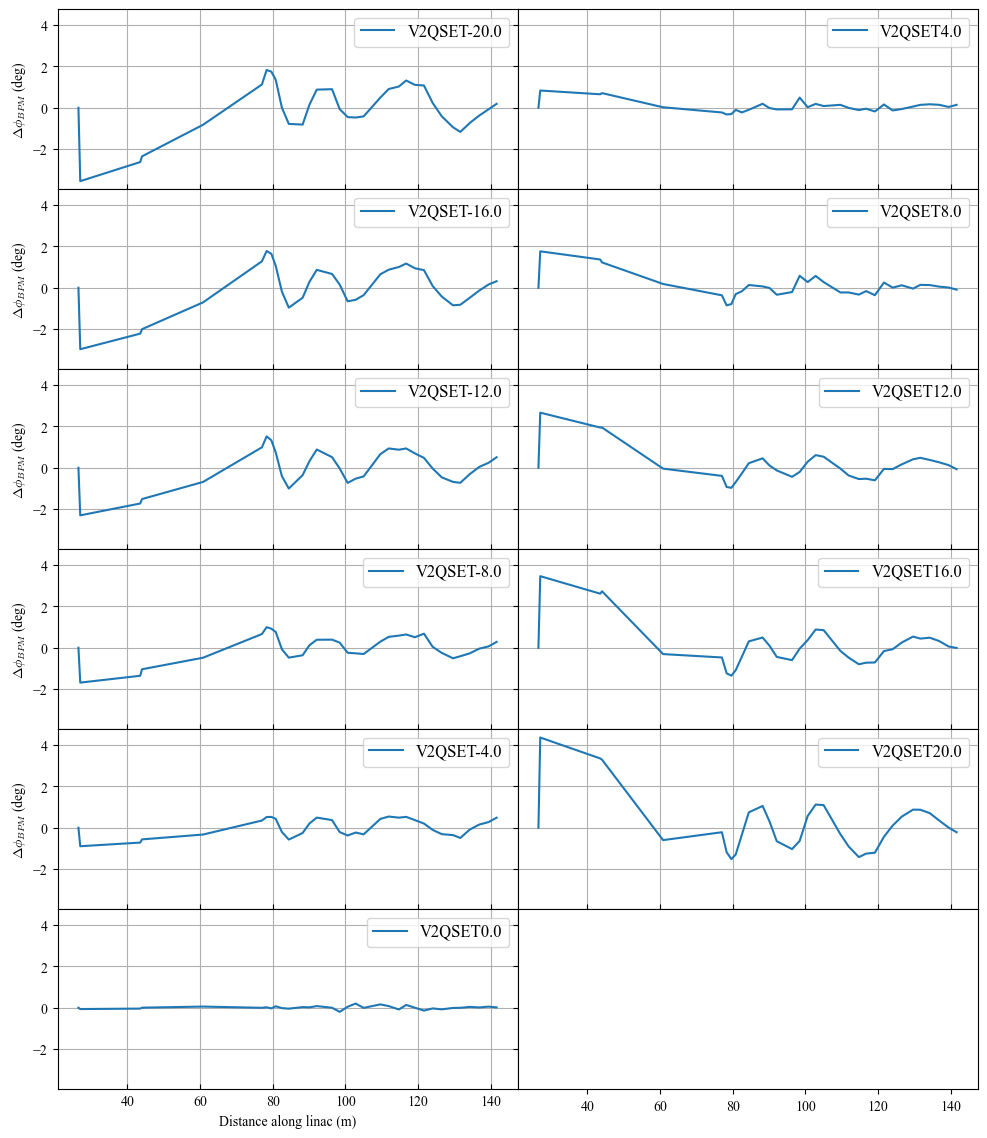

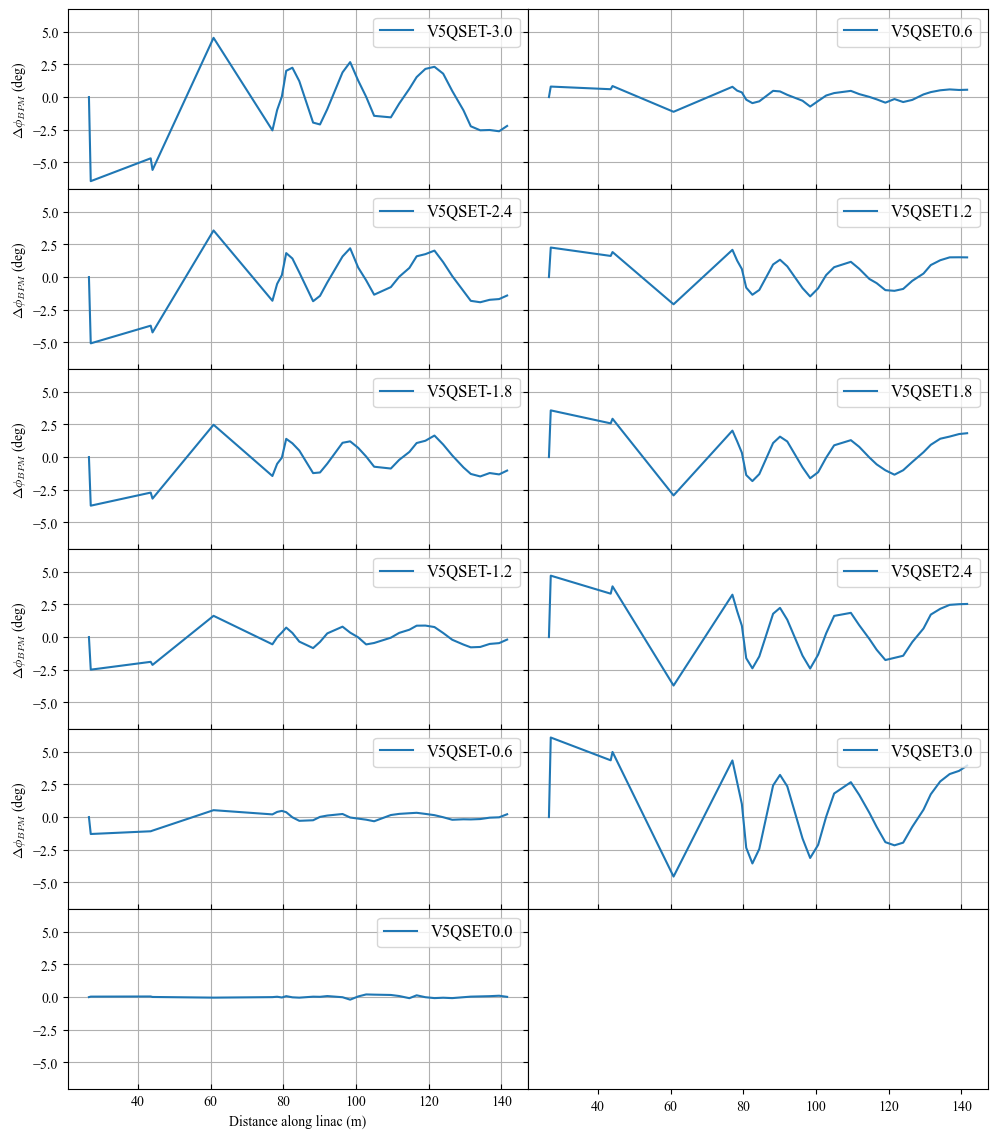

In [23]:
%matplotlib inline

nplots = ssdfmed[0][0].shape[0]
nrows = int(nplots/2) if nplots%2==0 else int(nplots/2)+1
print(nrows, nplots)
#devs = ['RFQPAH','V2QSET','V5QSET']
devs = ['V2QSET','V5QSET']
for i in range(2):
    fig, axs = plt.subplots(nrows,2, figsize=(10,12), sharex=True, sharey=True)
    for k in range(nplots):
        axs[int(k%(nplots/2))][int(k/(nplots/2))].plot(dist_data,ssdfmed[i][0].iloc[k,2:], label='%s%.1f'%(devs[i],ssdfmed[i][0].iloc[k,i]), marker='',linestyle='-')
        #axs[int(k%(nplots/2))][int(k/(nplots/2))].plot(dist_data,ssdfmed[i][1].iloc[k,3:-2], label='%s%.1f'%(devs[i],ssdfmed[i][1].iloc[k,0]), marker='o',linestyle='-')

        axs[int(k%(nplots/2))][int(k*2/(nplots))].legend(loc='upper right', fancybox=True, fontsize='large')
        axs[int(k%(nplots/2))][int(k*2/(nplots))].xaxis.set_tick_params(direction='in', which='major')
        axs[int(k%(nplots/2))][int(k*2/(nplots))].grid(True)
        #axs[int(k%(nplots/2))][int(k*2/(nplots))].set_ylim(-4.,5)
        if int(k%(nplots/2))==nrows-1:
            axs[int(k%(nplots/2))][int(k/(nplots/2))].set(xlabel='Distance along linac (m)')
        elif int(k/(nplots/2))%2==0:
            axs[int(k%(nplots/2))][int(k/(nplots/2))].set(ylabel='$\Delta \phi_{BPM}$ (deg)')
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(bottom=0.05)
    plt.subplots_adjust(top=0.95)
    plt.subplots_adjust(left=0.06)
    plt.subplots_adjust(right=0.98)

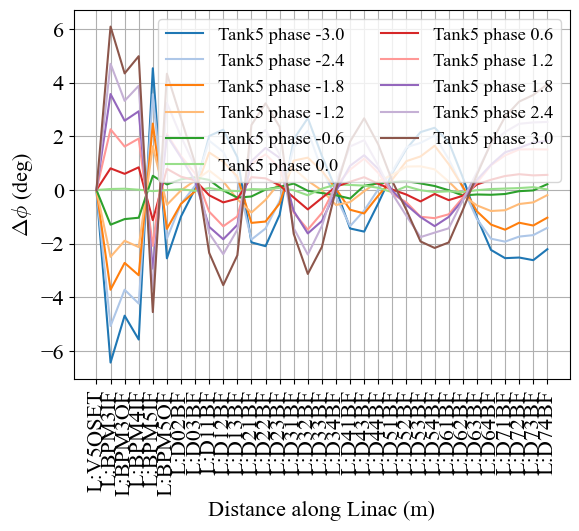

In [24]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
#[plt.plot(ssdfmed[0][0].iloc[k,2:], label='Tank2 phase %2.1f'%(ssdfmed[0][0].iloc[k,0]), marker='',linestyle='-') for k in range(11) ]
[plt.plot(ssdfmed[1][0].iloc[k,2:], label='Tank5 phase %2.1f'%(ssdfmed[1][0].iloc[k,1]), marker='',linestyle='-') for k in range(11) ]

plt.grid()
plt.legend(loc="upper right",fontsize = 'small',ncol=2)
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.xticks(rotation = 90);

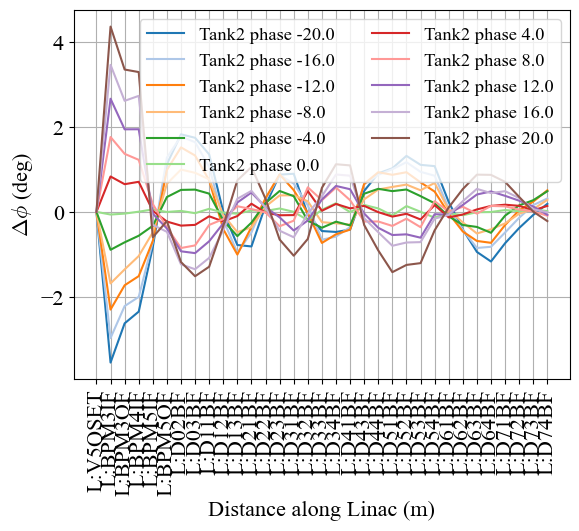

In [25]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})
[plt.plot(ssdfmed[0][0].iloc[k,2:], label='Tank2 phase %2.1f'%(ssdfmed[0][0].iloc[k,0]), marker='',linestyle='-') for k in range(11) ]
#[plt.plot(ssdfmed[1][0].iloc[k,2:], label='Tank5 phase %2.1f'%(ssdfmed[1][0].iloc[k,1]), marker='',linestyle='-') for k in range(11) ]

plt.grid()
plt.legend(loc="upper right",fontsize = 'small',ncol=2)
plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.xticks(rotation = 90);

## 2-phase model: RFQ phase is fixed

In [26]:
rfqdf = []
for i in range(11):
    rfqdf.append(fetch_slice(ddfs[0],['L:RFQPAH'],[-20+i*4],[1.]))

rfqdf =[df.sort_index().reset_index(drop=True) for df in rfqdf]
rfqdf = [df.dropna() for df in rfqdf]

#rfqdfmed= [[df.groupby(np.arange(len(df))//9).median() for df in s] for s in ssdf]
rfqdfmed= [df.groupby(np.arange(len(df))//9).mean() for df in rfqdf]

In [27]:
#train_data3 = rfqdf[5].iloc[:,1:].sample(frac=0.8, random_state=11)
#test_data3 = rfqdf[5].iloc[:,1:].drop(train_data3.index)

train_data3 = ddf1deg.sample(frac=0.8, random_state=11)
test_data3 = ddf1deg.drop(train_data3.index)

train_ft3, train_lbl3 = fetch_features_labels(train_data3,['L:V2QSET','L:V5QSET'])
test_ft3, test_lbl3 = fetch_features_labels(test_data3,['L:V2QSET','L:V5QSET'])

normal3 = preprocessing.Normalization(axis=-1)
normal3.adapt(np.array(train_ft3))

In [28]:
train_ft3.shape

(910, 32)

In [29]:
%%time

init_lr = 1e-3

model_2ph = build_and_compile_model_len(normal3, initial_lr, train_lbl3.shape[1])
model_2ph.summary()
history_2ph = train_model(model_2ph,train_ft3,train_lbl3,600,lr_time_based_decay)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 32)               65        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                        

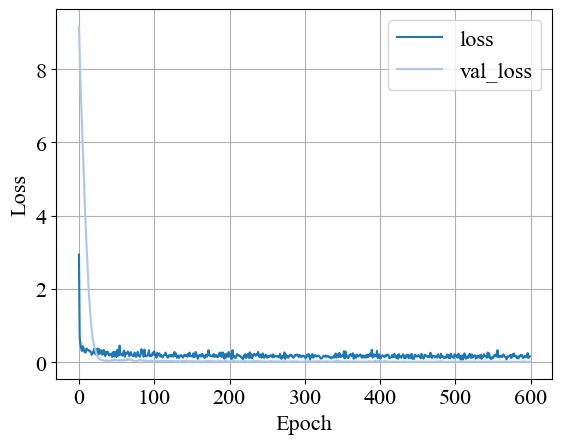

In [30]:
%matplotlib inline
plot_loss(history_2ph)

In [31]:
model_2ph.save('dnn_model_2ph_27042023')
# in the future, to load a trained model:
# loaded_model = tf.keras.models.load_model('dnn_model_2ph_12042023')

INFO:tensorflow:Assets written to: dnn_model_2ph_27042023\assets


INFO:tensorflow:Assets written to: dnn_model_2ph_27042023\assets


In [32]:
model_2ph.evaluate(test_ft3, test_lbl3, verbose=1)
testpred3 = model_2ph.predict(test_ft3)

8/8 [==============================] - 0s 39ms/step


C:\Users\Sheldon\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Sheldon\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


$\mu=-0.02$
$\sigma=0.13$
$\mu=0.01$
$\sigma=0.09$


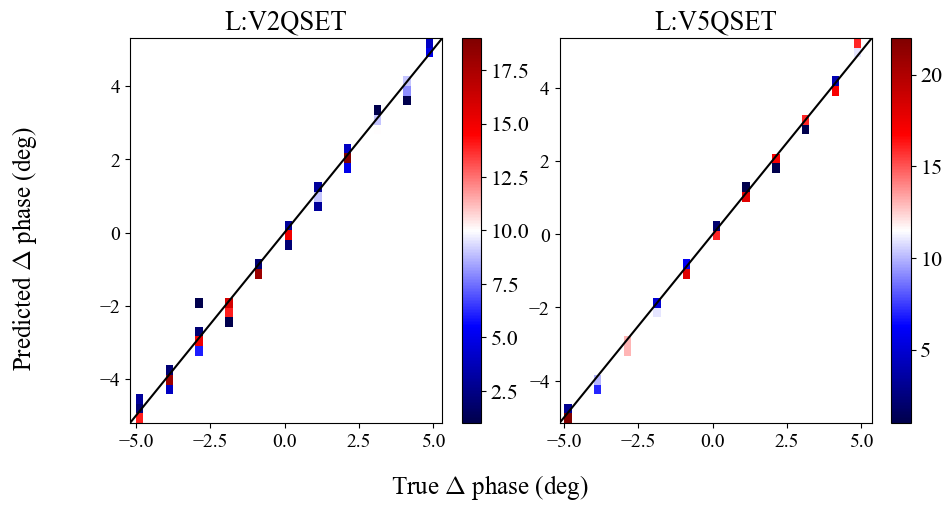

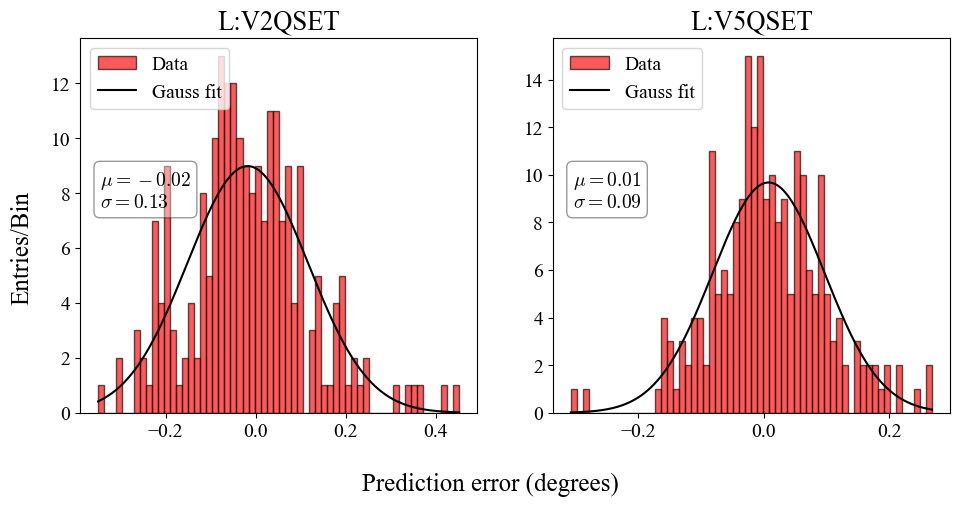

In [33]:
%matplotlib inline
plot_2dhist(testpred3,test_lbl3)
plot_1derror(testpred3,test_lbl3)

In [34]:
tt = [list(fetch_features_labels(df.iloc[:,1:],['L:V2QSET','L:V5QSET'])) for df in rfqdfmed]

preds = [model_2ph.predict(t[0]) for t in tt ]

4/4 [==============================] - 0s 4ms/step


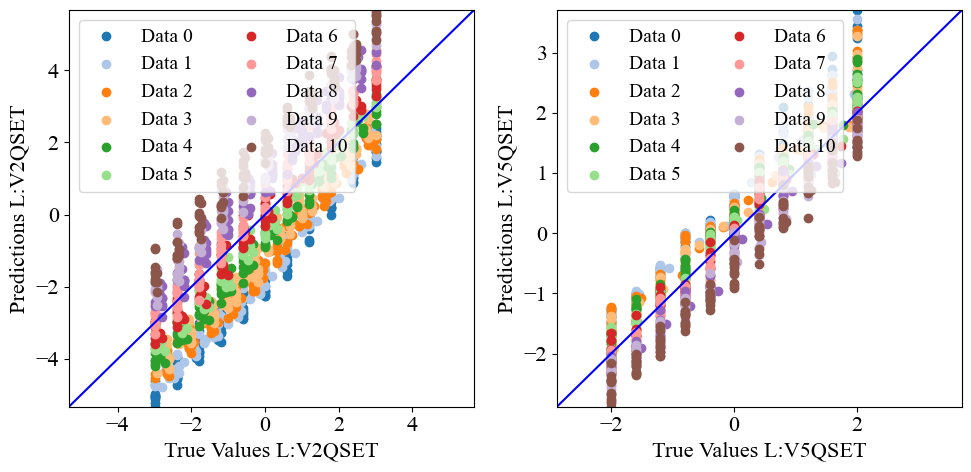

In [35]:
%matplotlib inline
plot_2dscatter_many(preds,[t[1] for t in tt])
#plot_2dhist(preds[5],tt[5][1])

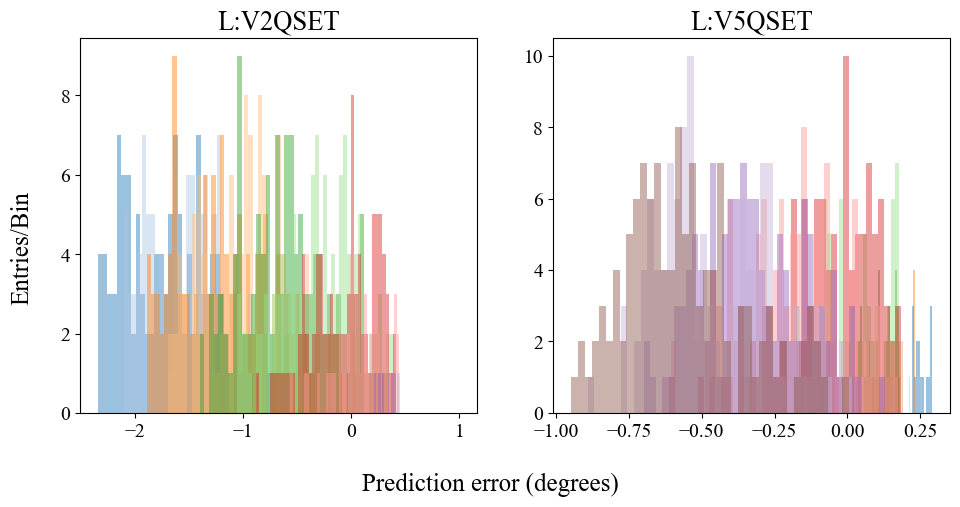

In [36]:
%matplotlib inline
#plot_1derror(preds[5],tt[5][1])
plot_1derror_many(preds,[t[1] for t in tt])

In [37]:
osc1 = [fetch_slice(df,['L:V2QSET','L:V5QSET'],[0,0],[0.2,0.2]) for df in rfqdf]
osc1 = [o.mean().to_frame().transpose() for o in osc1]

[print(osc.iloc[:,:5]) for osc in osc1]

#[df.to_csv('osc_varyRFQ_fixT2T5_%d.csv'%i) for i,df in enumerate(osc1)]
#rfqdfmed[5].to_csv('osc_fixRFQ_varyT2T5.csv')

predicted = [model_2ph.predict(osc.iloc[:,3:]) for osc in osc1]
print(predicted)
osc2 = [fetch_slice(rfqdfmed[5],['L:V2QSET','L:V5QSET'],pr[0],[0.3,0.29]) for pr in predicted ]
[print(osc.iloc[:,:3], pr[0]) for (osc,pr) in zip(osc2,predicted)]

    L:RFQPAH  L:V2QSET  L:V5QSET  L:BPM3IF  L:BPM3OF
0 -19.995117       0.0       0.0 -3.519287 -2.642822
    L:RFQPAH  L:V2QSET  L:V5QSET  L:BPM3IF  L:BPM3OF
0 -15.997314       0.0       0.0 -2.943115 -2.244873
    L:RFQPAH  L:V2QSET  L:V5QSET  L:BPM3IF  L:BPM3OF
0 -11.999512       0.0       0.0 -2.294922 -1.751709
   L:RFQPAH  L:V2QSET  L:V5QSET  L:BPM3IF  L:BPM3OF
0 -7.995605       0.0       0.0 -1.747437 -1.350098
   L:RFQPAH  L:V2QSET  L:V5QSET  L:BPM3IF  L:BPM3OF
0 -3.997803       0.0       0.0 -0.948486 -0.730591
   L:RFQPAH  L:V2QSET  L:V5QSET  L:BPM3IF  L:BPM3OF
0       0.0       0.0       0.0       0.0       0.0
   L:RFQPAH  L:V2QSET  L:V5QSET  L:BPM3IF  L:BPM3OF
0  4.003906       0.0       0.0  0.802002  0.593872
   L:RFQPAH  L:V2QSET  L:V5QSET  L:BPM3IF  L:BPM3OF
0  8.001709       0.0       0.0  1.773071  1.370239
    L:RFQPAH  L:V2QSET  L:V5QSET  L:BPM3IF  L:BPM3OF
0  12.005615       0.0       0.0  2.633057  1.970215
    L:RFQPAH  L:V2QSET  L:V5QSET  L:BPM3IF  L:BPM3OF
0  

[None, None, None, None, None, None, None, None, None, None, None]

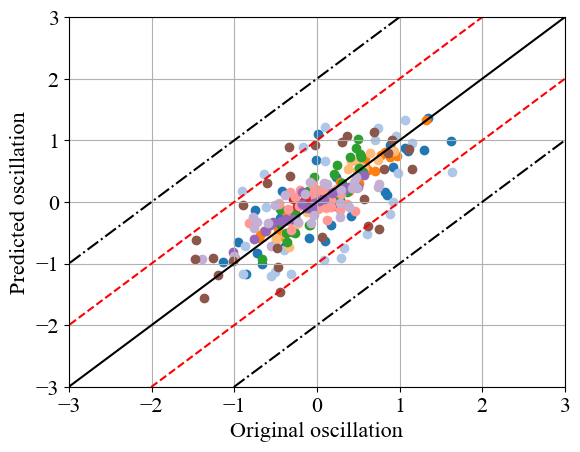

In [38]:
%matplotlib inline
#plt.scatter(osc1[5].iloc[:,3:],osc2[5].iloc[:,3:])
[plt.scatter(o1.mean()[9:],o2.mean()[9:], label='Data %d'%i) for i,(o1,o2) in enumerate(zip(osc1,osc2))]
plt.plot([-11,11],[-11,11],color='k', linestyle = '-')
plt.plot([-11,11],[-9,13],color='k', linestyle = '-.')
plt.plot([-11,11],[-13,9],color='k', linestyle = '-.')
plt.plot([-11,11],[-10,12],color='r', linestyle = '--')
plt.plot([-11,11],[-12,10],color='r', linestyle = '--')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.xlabel('Original oscillation')
plt.ylabel('Predicted oscillation')
#plt.legend()
plt.grid()

Text(0, 0.5, '$\\Delta \\phi_{BPM}$ (deg)')

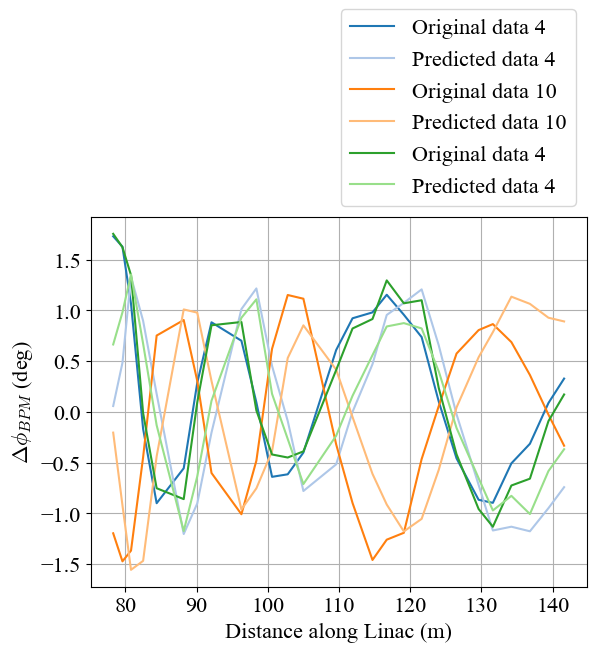

In [39]:
%matplotlib inline
plt.plot(dist_data[6:],osc1[1].mean()[8:], label = 'Original data 4')
plt.plot(dist_data[6:],osc2[1].mean()[8:], label = 'Predicted data 4')
plt.plot(dist_data[6:],osc1[10].mean()[8:], label = 'Original data 10')
plt.plot(dist_data[6:],osc2[10].mean()[8:], label = 'Predicted data 10')
plt.plot(dist_data[6:],osc1[0].mean()[8:], label = 'Original data 4')
plt.plot(dist_data[6:],osc2[0].mean()[8:], label = 'Predicted data 4')
#plt.xticks(rotation=90)
plt.grid()
plt.legend(loc='lower right', bbox_to_anchor = (1, 1))
plt.xlabel('Distance along Linac (m)')
plt.ylabel('$\Delta \phi_{BPM}$ (deg)')

In [40]:
# We interpolate the data to create larger number of grid points

from scipy.interpolate import griddata

#file = './osc_fixRFQ_varyT2T5.csv'
#dfrd = pd.read_csv(file,sep=',')
dfrd = rfqdf[5]


NPX=61
NPY=61

X, Y = np.mgrid[dfrd['L:V5QSET'].min():dfrd['L:V5QSET'].max():NPY*1j,
                dfrd['L:V2QSET'].min():dfrd['L:V2QSET'].max():NPX*1j]
points = (Y.ravel(),X.ravel())
bpms=dfrd.filter(regex="^(?!.*QSET|Unnamed).*").columns
print(bpms)

dfnew=pd.DataFrame(zip(Y.ravel(),X.ravel()),columns=["L:V2QSET","L:V5QSET"])
for bpm in bpms:
    dfnew[bpm] = griddata((dfrd['L:V2QSET'],dfrd['L:V5QSET']), dfrd[bpm], points, method='linear')
    
#print(dfnew)
#print(df)

Index(['L:RFQPAH', 'L:BPM3IF', 'L:BPM3OF', 'L:BPM4IF', 'L:BPM5IF', 'L:BPM5OF',
       'L:D02BF', 'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF', 'L:D21BF',
       'L:D22BF', 'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF', 'L:D34BF',
       'L:D41BF', 'L:D43BF', 'L:D44BF', 'L:D51BF', 'L:D52BF', 'L:D53BF',
       'L:D54BF', 'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF', 'L:D71BF',
       'L:D72BF', 'L:D73BF', 'L:D74BF'],
      dtype='object')


In [41]:
osc3 = [fetch_slice(dfnew,['L:V2QSET','L:V5QSET'],pr[0],[0.058,0.031]) for pr in predicted ]
[print(osc.iloc[:,:3], pr[0]) for (osc,pr) in zip(osc3,predicted)]


      L:V2QSET  L:V5QSET  L:RFQPAH
2086      -1.8  0.266667       0.0 [-1.802  0.295]
      L:V2QSET  L:V5QSET  L:RFQPAH
2089      -1.5  0.266667       0.0 [-1.533  0.284]
      L:V2QSET  L:V5QSET  L:RFQPAH
2155      -1.0  0.333333       0.0 [-1.031  0.342]
      L:V2QSET  L:V5QSET  L:RFQPAH
2096      -0.8  0.266667       0.0 [-0.837  0.258]
      L:V2QSET  L:V5QSET  L:RFQPAH
2040      -0.3       0.2       0.0 [-0.321  0.19 ]
      L:V2QSET  L:V5QSET  L:RFQPAH
1860       0.0       0.0       0.0 [-0.036 -0.013]
      L:V2QSET  L:V5QSET  L:RFQPAH
1802       0.3 -0.066667       0.0 [ 0.284 -0.036]
      L:V2QSET  L:V5QSET  L:RFQPAH
1441       0.8 -0.466667       0.0
1442       0.9 -0.466667       0.0 [ 0.855 -0.444]
      L:V2QSET  L:V5QSET  L:RFQPAH
1324       1.3      -0.6       0.0 [ 1.285 -0.59 ]
      L:V2QSET  L:V5QSET  L:RFQPAH
1084       1.7 -0.866667       0.0 [ 1.713 -0.89 ]
      L:V2QSET  L:V5QSET  L:RFQPAH
1027       2.1 -0.933333       0.0 [ 2.129 -0.908]


[None, None, None, None, None, None, None, None, None, None, None]

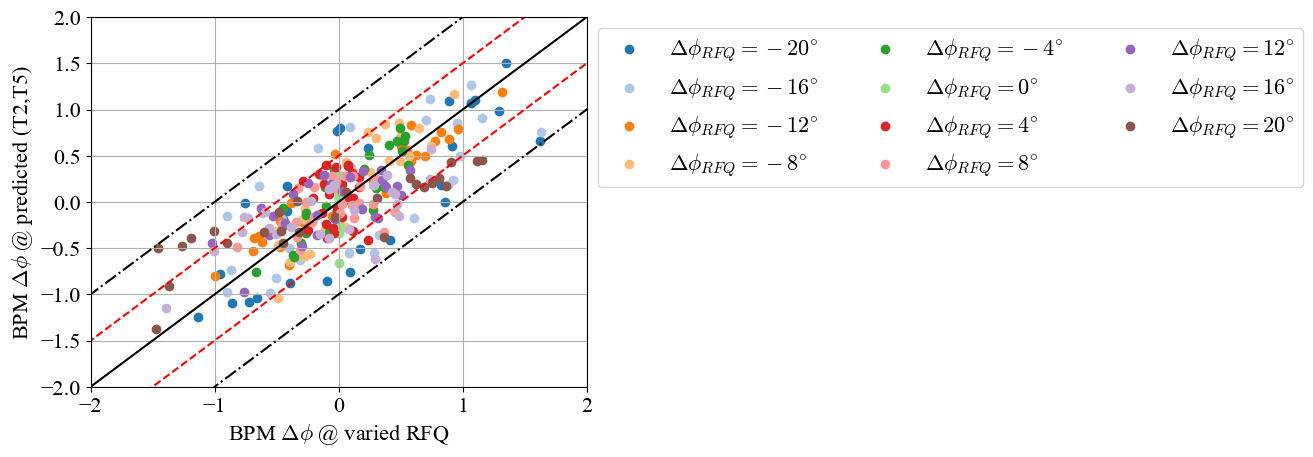

In [42]:
%matplotlib inline

labels=np.arange(-20,21,4)
#plt.scatter(osc1[5].iloc[:,3:],osc2[5].iloc[:,3:])
[plt.scatter(o1.mean()[9:],o2.mean()[9:], label='$\Delta\phi_{RFQ}=%d^{\circ}$'%labels[i]) for i,(o1,o2) in enumerate(zip(osc1,osc3))]
plt.plot([-11,11],[-11,11],color='k', linestyle = '-')
plt.plot([-11,11],[-10,12],color='k', linestyle = '-.')
plt.plot([-11,11],[-12,10],color='k', linestyle = '-.')
plt.plot([-11,11],[-10.5,11.5],color='r', linestyle = '--')
plt.plot([-11,11],[-11.5,10.5],color='r', linestyle = '--')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel('BPM $\Delta\phi$ @ varied RFQ')
plt.ylabel('BPM $\Delta\phi$ @ predicted (T2,T5)')
plt.legend(ncol=3, bbox_to_anchor = (1, 1))
plt.grid()

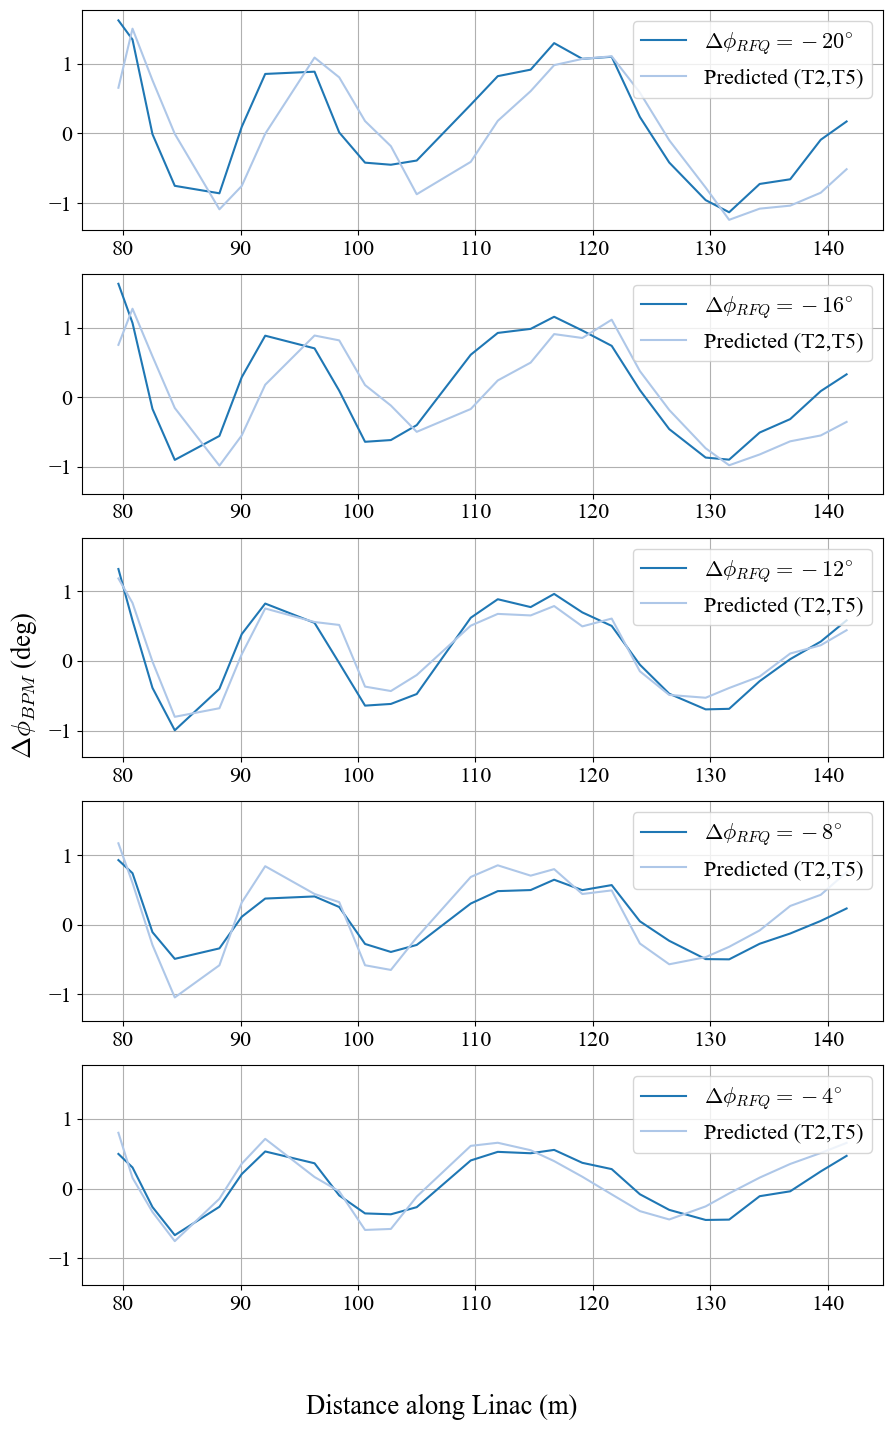

In [43]:
%matplotlib inline
nplots=5
fig, ax = plt.subplots(int(nplots),1, figsize=(9,3*int(nplots)),sharey=True)
for i in range(nplots):
    ax[i].plot(dist_data[7:],osc1[i].mean()[9:], label = '$\Delta\phi_{RFQ}=%d^{\circ}$'%labels[i])
    ax[i].plot(dist_data[7:],osc3[i].mean()[9:], label = 'Predicted (T2,T5)')
    ax[i].grid()
    ax[i].legend(loc='upper right')
    
fig.supxlabel('Distance along Linac (m)')
fig.supylabel('$\Delta \phi_{BPM}$ (deg)')

plt.subplots_adjust(bottom=0.1)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.1)
plt.subplots_adjust(right=0.99)


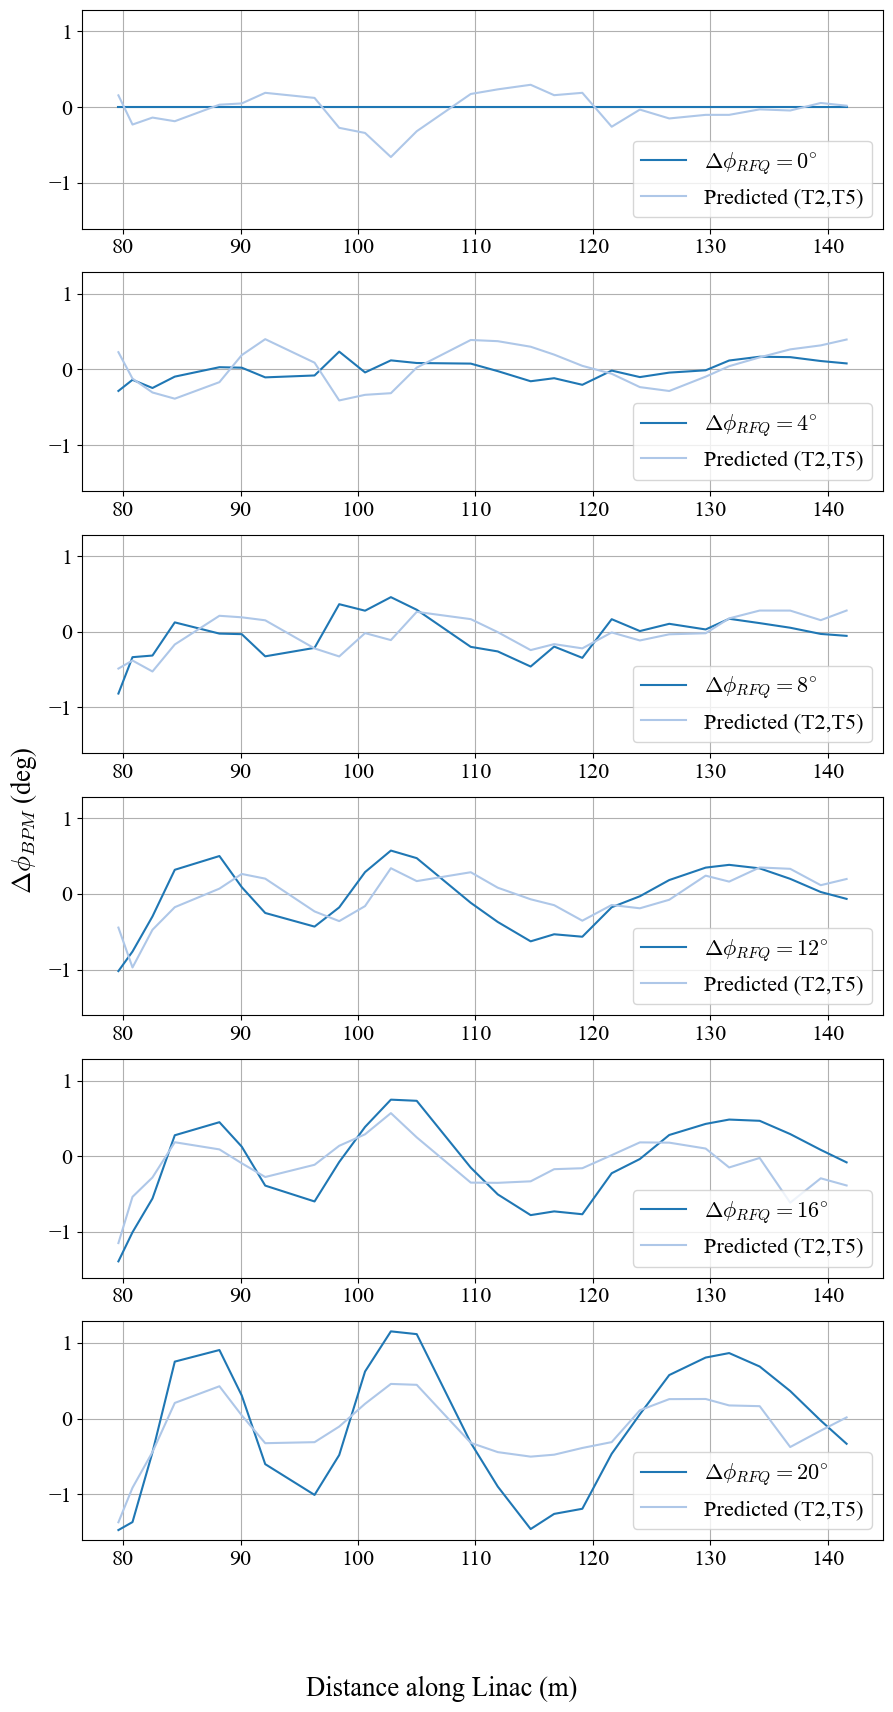

In [44]:
%matplotlib inline
nplots=6
fig, ax = plt.subplots(int(nplots),1, figsize=(9,3*int(nplots)),sharey=True)
for i in range(nplots):
    ax[i].plot(dist_data[7:],osc1[i+5].mean()[9:], label = '$\Delta\phi_{RFQ}=%d^{\circ}$'%labels[i+5])
    ax[i].plot(dist_data[7:],osc3[i+5].mean()[9:], label = 'Predicted (T2,T5)')
    ax[i].grid()
    ax[i].legend(loc='lower right')
    
fig.supxlabel('Distance along Linac (m)')
fig.supylabel('$\Delta \phi_{BPM}$ (deg)')

plt.subplots_adjust(bottom=0.1)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.1)
plt.subplots_adjust(right=0.99)